In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

np.random.seed(0)

In [2]:
import Preprocessor
import Parameters
import HHMM
import Visualisor

In [3]:
pars = Parameters.Parameters()

pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'FoVeDBA_low':{'thresh':5,'corr':True,'f':'gamma'}}]#,
                  #'Vz':{'corr':True,'f':'normal'}}]

prep = Preprocessor.Preprocessor(pars)

In [4]:
np.set_printoptions(suppress=True,precision=4)

In [5]:
s_dive = 130
e_dive = 200
pars.K[0] = 3
pars.K[1] = 3
pars.share_fine_state = True
HHMM_file = 'HHMM_k_%s_%s_dives_%s_%s_same_fine_states' % (pars.K[0],pars.K[1],s_dive,e_dive)
print(HHMM_file)

HHMM_k_3_2_dives_130_200_diff_fine_states_Vz


# Preprocess Data

In [6]:
df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

df = prep.prune_cols(df)

df = prep.prune_times(df,
                      pars.stime,
                      pars.etime,
                      pars.drop_times)

df = prep.fix_pressure(df)

df = prep.find_Vz(df)

df = prep.smooth_columns(df,
                         pars.smoother,
                         pars.smooth_cols)

df,dive_df = prep.find_dives(df)

data = prep.get_all_features(df,dive_df)

viz = Visualisor.Visualisor(pars,data,df)

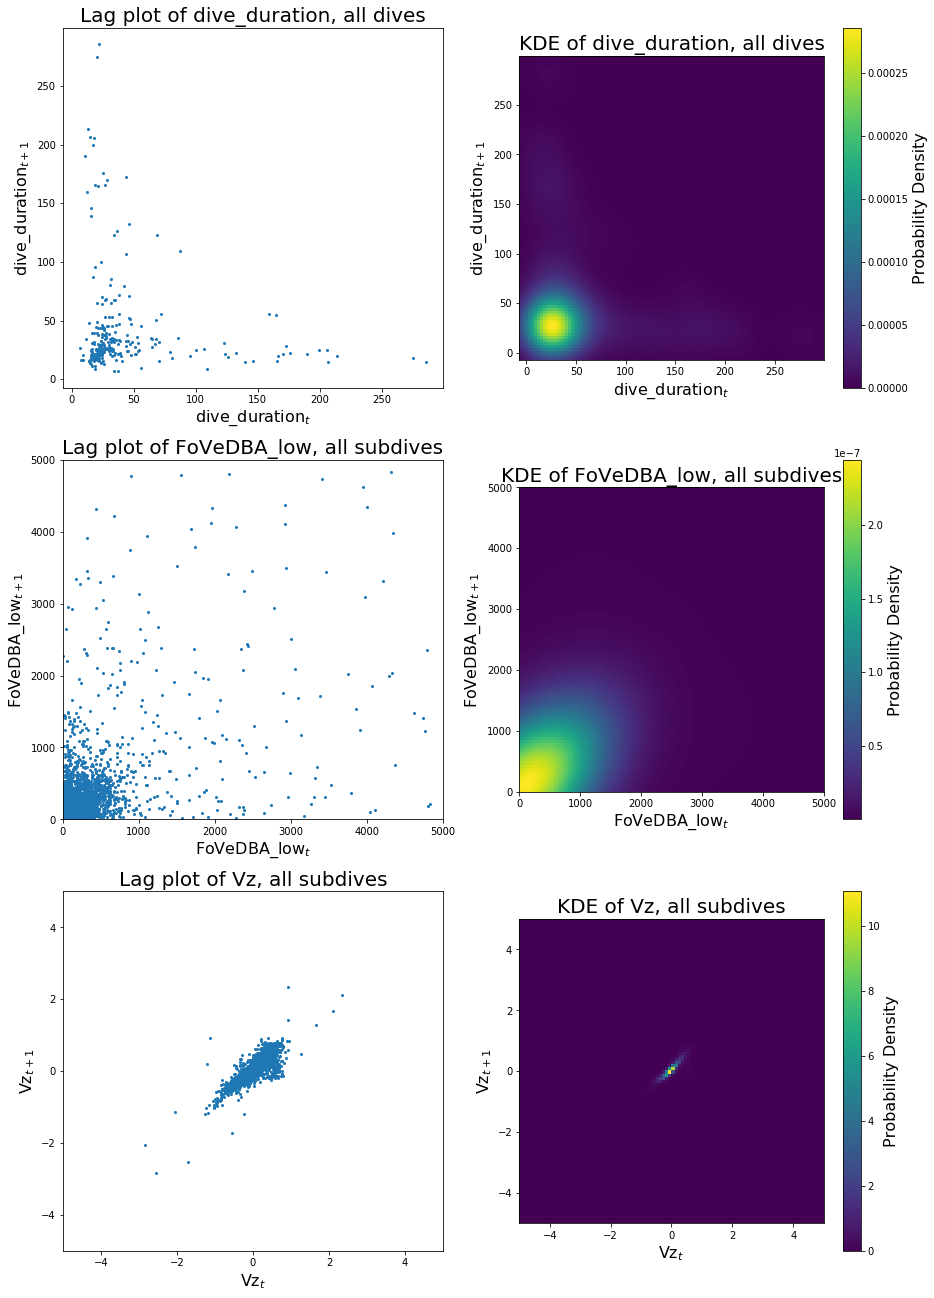

In [7]:
viz.lagplot(lims={'peak_jerk':[0,50],
                  'roll_at_pj':[0,1],
                  'heading_var':[0,0.2],
                  'FoVeDBA_low':[0,5000],
                  'FoVeDBA_high':[0,10],
                  'Vz':[-5,5]})

# Train HHMM

In [8]:
deep_data = [data[i] for i in range(s_dive,e_dive)]

hhmm = HHMM.HHMM(pars,deep_data)
print(hhmm.likelihood(deep_data))

# initial crude theta
hhmm.theta[0]['dive_duration']['mu'][0] = 200
hhmm.theta[0]['dive_duration']['sig'][0] = 100

hhmm.theta[0]['dive_duration']['mu'][1] = 40
hhmm.theta[0]['dive_duration']['sig'][1] = 20

hhmm.theta[0]['dive_duration']['mu'][2] = 30
hhmm.theta[0]['dive_duration']['sig'][2] = 15

# inital fine theta
#hhmm.theta[1][0]['FoVeDBA_low']['mu'][1] = 10
#hhmm.theta[1][0]['FoVeDBA_low']['sig'][1] = 50
#hhmm.theta[1][0]['FoVeDBA_low']['mu'][0] = 250
#hhmm.theta[1][0]['FoVeDBA_low']['sig'][0] = 250

#hhmm.theta[1][1]['FoVeDBA_low']['mu'][0] = 10
#hhmm.theta[1][1]['FoVeDBA_low']['sig'][0] = 50
#hhmm.theta[1][1]['FoVeDBA_low']['mu'][1] = 400
#hhmm.theta[1][1]['FoVeDBA_low']['sig'][1] = 1000

#hhmm.theta[1][2]['FoVeDBA_low']['mu'][1] = 10
#hhmm.theta[1][2]['FoVeDBA_low']['sig'][1] = 50
#hhmm.theta[1][2]['FoVeDBA_low']['mu'][0] = 250
#hhmm.theta[1][2]['FoVeDBA_low']['sig'][0] = 250

try:
    hhmm = hhmm.load(HHMM_file)
except:
    print('HHMM not found. Training new model')
    hhmm.train_DM(deep_data)
    hhmm.save(HHMM_file)
    
#data0,df0 = hhmm.label_df(data,df)
print(hhmm.likelihood(deep_data))

-13529.08870199877
HHMM not found. Training new model
15748.28265118599
-7632.774671612207


In [9]:
print(hhmm.likelihood(deep_data))
data0,df0 = hhmm.label_df(data,df)

-7632.774671612207


In [10]:
hhmm.theta

[{'dive_duration': {'mu': array([53.8706, 32.7319, 42.4157]),
   'sig': array([50.911 , 24.9845, 22.258 ]),
   'corr': array([-1.1627, -3.409 , -1.275 ])}},
 [{'FoVeDBA_low': {'mu': array([223.8279,   9.5779]),
    'sig': array([239.859 ,   6.6339]),
    'corr': array([-2.7481, -2.8547])},
   'Vz': {'mu': array([-0.069 ,  0.2294]),
    'sig': array([0.1346, 0.049 ]),
    'corr': array([2.9462, 2.32  ])}},
  {'FoVeDBA_low': {'mu': array([ 13.0647, 949.6128]),
    'sig': array([  84.156 , 2049.5506]),
    'corr': array([ 1.198, -4.535])},
   'Vz': {'mu': array([-0.1959,  0.1991]),
    'sig': array([0.1285, 0.4013]),
    'corr': array([-1.9716, -0.4965])}},
  {'FoVeDBA_low': {'mu': array([243.7812,  18.6664]),
    'sig': array([296.5053,  21.9629]),
    'corr': array([-6.5295, -5.1192])},
   'Vz': {'mu': array([-0.1039,  0.2013]),
    'sig': array([0.2227, 0.2535]),
    'corr': array([-2.9034, -2.8376])}}]]

# Visualize Results

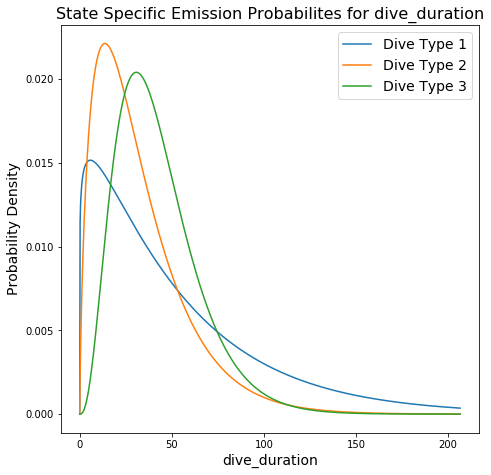

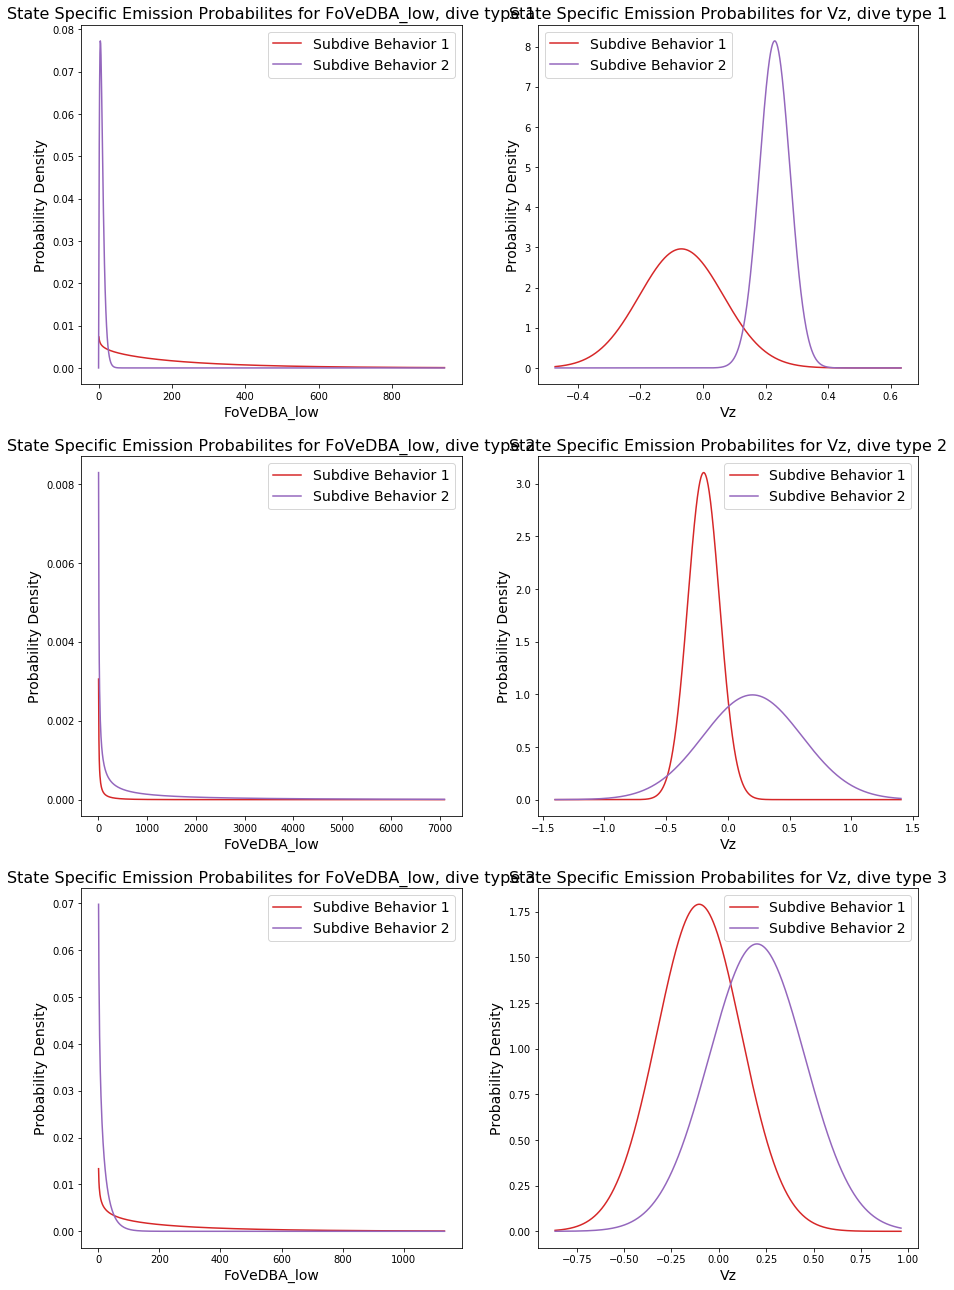

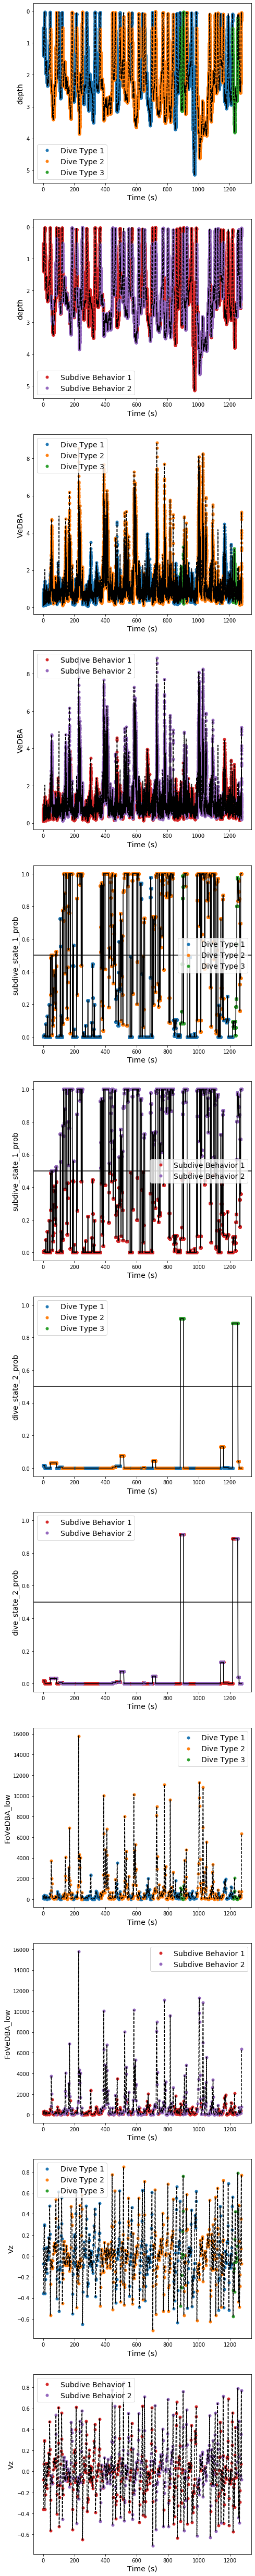

In [20]:
importlib.reload(Visualisor)
viz = Visualisor.Visualisor(pars,data0,df0)
viz.hhmm = hhmm
viz.plot_emission_probs(0)
viz.plot_emission_probs(1)
#viz.print_ptms()
viz.plot_dive_features(10,50,['depth','VeDBA','subdive_state_1_prob','dive_state_2_prob'],
                               ['FoVeDBA_low','Vz'])

# Things to note:

    - Subdive states are much less sure than dive types
    - Subdive states are more uncertain in shallow dives than deep dives
        - should probably make different dstribtuions within different dive types
    - VeDBA is very different within shallow dives compared to deep dives
        - support for activity-specific use of energy readings

# Future Steps:

    - Include other features (high-frequency VeDBA, roll, heading variance, peak jerk, etc.?)
    - Use different subdive behaviors for different dive types
    - Figure out what number of states in each level
    - Write paper on fine-scale HHMMs and equivalence between correlated HMMs and continuous time models